In [1]:
import islpy as isl
from latex_op import display_latex
from islplot_support import plot_uset, plot_umap

# Dependence Analysis
The key to preserving the program semantics, when the program is being transformed,
lies in ensuring that the same values are written to and read from the memory, and in the same order.
Conventionally, this is expressed using *data dependences*, which impose a partial execution order on the program.
The power of the polyhedral model lies in its ability to compute exact data dependences at the statement instance level.

Two statement instances are said to be *dependent* if one is executed before another, they access the same array element, and at least one access writes to that element.

In the "Schedules" example, we learned how to define the order in which statement instances are executed.
In the "Memory Access" example, we defined a relation of *potentially dependent* statement instances
that access the same array element and at least one access is a write.
The simplest version of dependence analysis is a combination of these two parts, so let us pick up where we stopped.

We are give the polynomial multiplication kernel
```c
double X[10], Y[10], Z[20];

for (int i = 0; i <= 20; ++i)
S:  Z[i] = 0.;
for (int i = 0; i <= 10; ++i)
    for (int j = 0; j <= 10; ++j)
T:      Z[i + j] += A[i] * B[j];
```
and know how to define domains, schedules and access relations.


In [2]:
domain = isl.UnionSet("{S[i]: 0 <= i <= 20; T[i,j]: 0 <= i,j <= 10}")
schedule = isl.UnionMap("{S[i]->[t0,t1,t2]: t0 = 0 and t1 = i and t2 = 0; T[i,j]->[t0,t1,t2]: t0=1 and t1=i and t2=j}")
A_S_Z = isl.Map("{S[i]->Z[a]: a = i and 0 <= a,i <= 20}")
A_T_Z = isl.Map("{T[i,j]->Z[a]: a = i + j and 0 <= i,j <= 10 and 0 <= a <= 20}")
A_T_A = isl.Map("{T[i,j]->A[a]: a = i and 0 <= a <= 20 and 0 <= i,j <= 10}")
A_T_B = isl.Map("{T[i,j]->B[a]: a = j and 0 <= a <= 20 and 0 <= i,j <= 10}")
writes = isl.UnionMap(A_S_Z).union(A_T_Z)
reads = isl.UnionMap(A_T_Z).union(A_T_A).union(A_T_B)

We can also compute the set of statement instance pairs (a relation is essentially a set of pairs) that
access the same array element.

## Plugging in Schedule Information
Because statement instances are executed following the lexicographic order of their respective dates,
we need a way to express it in the relations.
In the simplest case, we enforce the schedules for all statements to live in the same *space*.
For example, we added an auxiliary dimension $t_2$ to the schedule for `S` simply to have as many dimensions for `S` as for `T`.
*isl* then allows us to a define a map of "lexicographic less-than".

In [3]:
schedule_space = isl.Set("{[t0,t1,t2]:}").get_space()
precedes = isl.Map.lex_lt(schedule_space)
display_latex(precedes)

<IPython.core.display.Math object>

This map basically follows the definition of the lexicographic order.
Compare first pair of elements.
If one precedes another, the order is established.  Otherwise assume they are equal and compare the second pair.
Proceed until the final pair.
The `precedes` relation contains pairs of tuples where the first one lexicographically precedes the second one.

### Question
Apply the `schedule` to the `domain` so as to map it to the schedule space.
Save the result as `scheduled_domain`.

In [4]:
#!Solution
scheduled_domain = domain.apply(schedule)
display_latex(scheduled_domain)

<IPython.core.display.Math object>

Now we know how to move the relation from domain space to the schedule space: apply the schedule relation to everything in the domain space.

### Question
Check that $\mathtt{S}(2)$ is executed before $\mathtt{T}(0,0)$.

*Hint 1*: define a map between the two instances in question.<br>
*Hint 2*: once in schedule space, you can check if the relation is a subset of `precedes`.

In [5]:
#!Solution
rel = isl.UnionMap("{S[i] -> T[a,b]: i = 2 and a = 0 and b = 0}")
rel = rel.apply_domain(schedule).apply_range(schedule)
print(rel.is_subset(precedes))

True


## Memory-based Dependence Analysis
### Flow Dependences
Flow dependences appear when an array element is first written by one statement instance and then read by another statement instance.
The "writer" instance must be performed first.
Therefore, we first compose the `writes` union map on the left with inverted `reads` union map on the right,
$\mathtt{writes} \circ \mathtt{reads}^{-1}$.
Then we transform it to the schedule space and intersect the result with the lexicographic precedence relation in the schedule space so as to
only keep the pairs where the dependence *source* (first date) is executed before its *sink* (second date).

In [6]:
dep_flow = writes.apply_range(reads.reverse())
dep_flow = dep_flow.apply_domain(schedule).apply_range(schedule)
dep_flow = dep_flow.intersect(precedes)
display_latex(dep_flow)

<IPython.core.display.Math object>

The resulting relation is between *execution dates* rather than between points.
To transform it back to the domain space, recall that relations can be easily inverted.
The inverted schedule relation maps execution dates to statement instances.

In [7]:
dep_flow = dep_flow.apply_domain(schedule.reverse()).apply_range(schedule.reverse())
display_latex(dep_flow)

<IPython.core.display.Math object>

We see a dependence between different instances of T, which we could analyze and compare with *potentially* dependent statement relation.

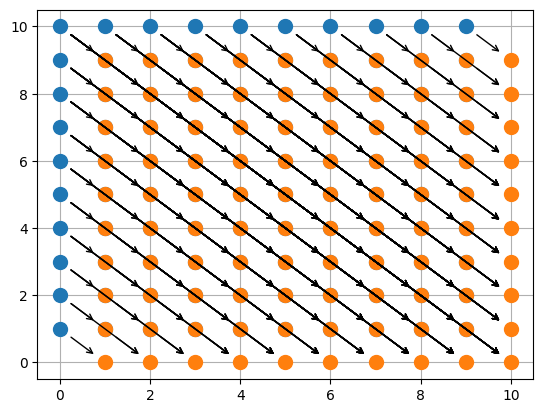

In [8]:
dep_flow_T = dep_flow.intersect(isl.UnionMap("{T[i,j]->T[i',j']:}"))
potential = writes.apply_range(reads.reverse())
potential = potential.intersect(isl.UnionMap("{T[i,j]->T[i',j']:}"))

plot_umap(dep_flow_T)

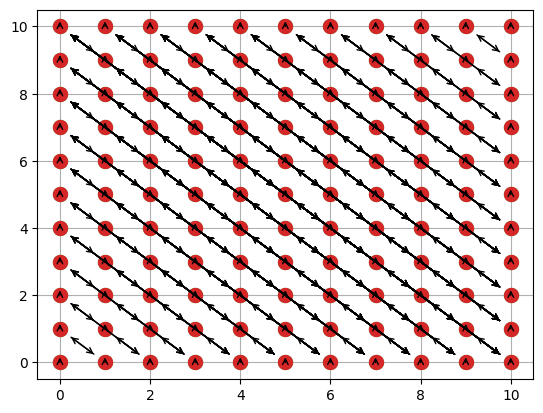

In [9]:
plot_umap(potential)

The first thing we observe that self-dependences of statement instances are gone.
Indeed, a statement instance cannot be executed before itself.

### Question
Plot the dependence *samples* for the instance $\mathtt{T}(4,2)$, i.e. the statements instances it depends upon and the statement instances that depend on it.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

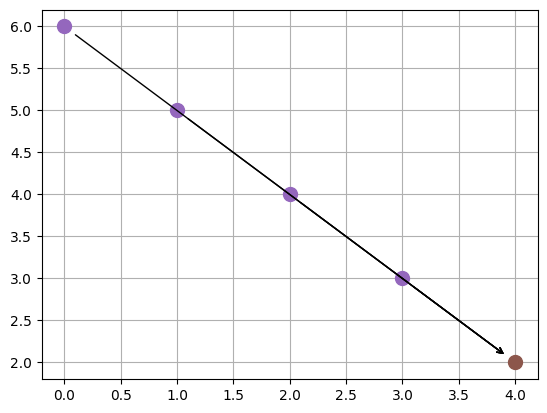

In [10]:
#!Solution
point = isl.Set("{T[i,j]: i = 4 and j = 2}")
sources = dep_flow_T.intersect_range(point)
sinks = dep_flow_T.intersect_domain(point)
display_latex(sources)
display_latex(sinks)

plot_umap(sources)

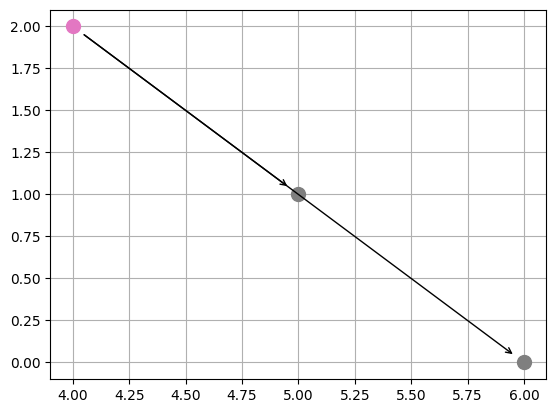

In [11]:
plot_umap(sinks)

Now you see that it depends on statement instances that access the same array element and are executed *before* it.
Similarly, only the statement instances executed *after* the given statement depend on it.

### Anti and Output Dependences
Anti-dependences are the inverse of flow dependences, that is write-after-read.
Respecting them means that the value will not be overwritten before it is read.
Output dependences, or write-after-write, preserve the order of writes.
Both of them are sometimes called *false* dependences in a sense that the *sink* statement instance does not actually *depend* on the *data* produced by the *source* statement instance.
It rather needs to be executed later to avoid interference with other statement instances.

The *sink* of the false dependences is always as a write access while the source can be either a read or write.
Therefore, we compose the union of reads and writes on the left with inverted writes on the right
$$
(\mathtt{reads} \cup \mathtt{writes}) \circ \mathtt{writes}^{-1}
$$
We then proceed as before.

In [12]:
dep_false = writes.union(reads).apply_range(writes.reverse())
dep_false = dep_false.apply_domain(schedule).apply_range(schedule)
dep_false = dep_false.intersect(precedes)
dep_false = dep_false.apply_domain(schedule.reverse()).apply_range(schedule.reverse())
display_latex(dep_false)

<IPython.core.display.Math object>

In our example, false dependences correspond exactly to flow dependences because `S` only writes and `T` reads and writes the same element.
It is not generally the case.

In [13]:
print(dep_false.is_equal(dep_flow))

True


### Question: Input Dependences
Even though they are usually not enforced, *input*, or read-after-read, dependences can be useful in program optimization.
Compute the input dependences similarly to the two previous cases.

In [14]:
#!Solution
dep_input = reads.apply_range(reads.reverse())
dep_input = dep_input.apply_domain(schedule).apply_range(schedule)
dep_input = dep_input.intersect(precedes)
dep_input = dep_input.apply_domain(schedule.reverse()).apply_range(schedule.reverse())
display_latex(dep_input)

<IPython.core.display.Math object>

Input dependence seems to differ from flow and false once.
In particular, only instances of `T` are involved in this dependence.
This is due to the fact that `S` never reads a value.

### Question
Plot dependence *samples* of the input dependence.

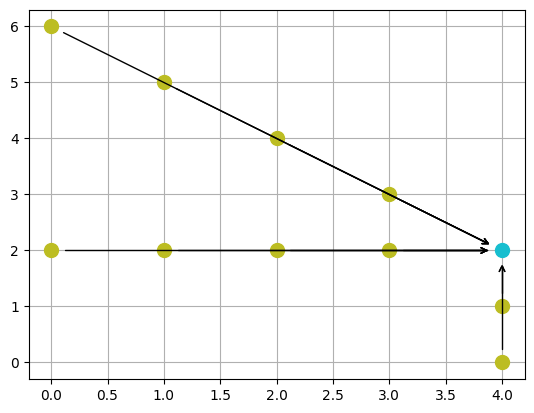

In [15]:
#!Solution
point = isl.Set("{T[i,j]: i = 4 and j = 2}")
sources = dep_input.intersect_range(point)
sinks = dep_input.intersect_domain(point)

plot_umap(sources)

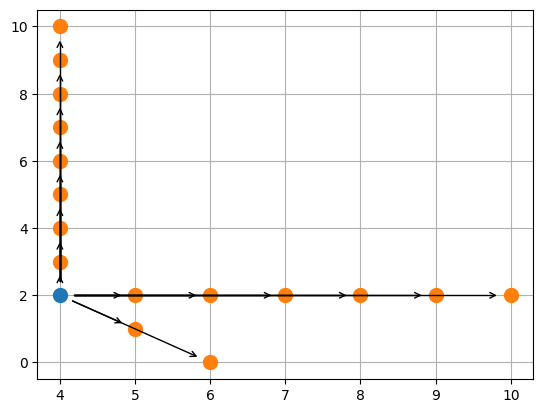

In [16]:
plot_umap(sinks)

The complex pattern of dependences is caused by reading from multiple different arrays in the same statement intances

## Value-based Analysis
You may observe that each statement instance depends on *all* instances that access the same array element.
Yet is it not always necessary.
Consider the flow dependence pattern for `T(4,2)` and `T(5,1)`.

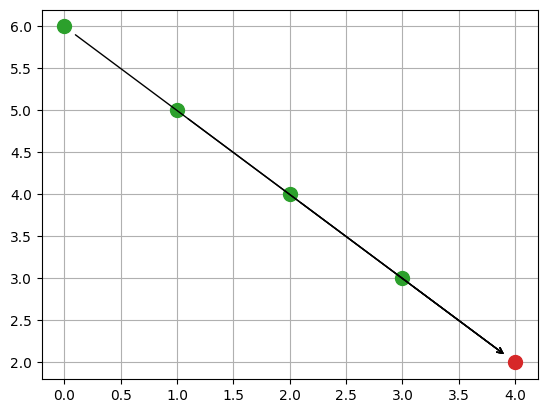

In [17]:
point1 = isl.Set("{T[i,j]: i = 4 and j = 2}")
point2 = isl.Set("{T[i,j]: i = 5 and j = 1}")
sources1 = dep_flow_T.intersect_range(point1)
sources2 = dep_flow_T.intersect_range(point2)

plot_umap(sources1)

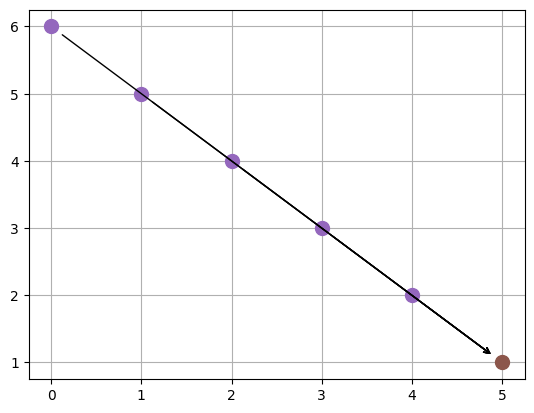

In [18]:
plot_umap(sources2)

`T(5,1)` depends on all the same instances as `T(4,2)` and on `T(4,2)` itself.

In [19]:
print(sources2.domain().subtract(point1).is_equal(sources1.domain()))

True


If `T(4,2)` needs to be scheduled after `T(3,3)` and `T(5,1)` needs to be scheduled after `T(4,2)`, then
`T(5,1)` also needs to be scheduled after `T(3,3)`.  So the dependence between these two instances is *transitively covered* by
dependences between other instances.
We can remove the transitively covered flow dependences safely.
This can be done by computing lexicographically largest source instance for any sink instance in a dependence, and by removing all the other sources.

Such computation is non-trivial and may involve solution of a linear optimization problem.  *isl* provides functionality to perform this *value-based* analysis directly.
However, it uses a more elaborate *tree* structure for the schedules.
For the sake of this example, we will provide this schedule without further explanation.

In [20]:
schedule = isl.Schedule('{ domain: "{ T[i, j] : 0 <= i <= 10 and 0 <= j <= 10; S[i] : 0 <= i <= 20 }", child: { sequence: [{ filter: "{ S[i] }", child: { schedule: "[{S[i] -> [(i)]}, {S[i] -> [(0)]}]" }}, { filter: "{ T[i, j] }", child: { schedule: "[{T[i, j] -> [(i)]}, {T[i, j] -> [(j)]}]" }} ] } }')
print(schedule)

{ domain: "{ S[i] : 0 <= i <= 20; T[i, j] : 0 <= i <= 10 and 0 <= j <= 10 }", child: { sequence: [ { filter: "{ S[i] }", child: { schedule: "[{ S[i] -> [(i)] }, { S[i] -> [(0)] }]" } }, { filter: "{ T[i, j] }", child: { schedule: "[{ T[i, j] -> [(i)] }, { T[i, j] -> [(j)] }]" } } ] } }


Now it is possible to set up the *value-based* dependence analysis

In [21]:
uai = isl.UnionAccessInfo.from_sink(reads)
uai = uai.set_must_source(writes)
uai = uai.set_schedule(schedule)
flow = uai.compute_flow()
dep_flow_precise = flow.get_may_dependence()
display_latex(dep_flow_precise)

<IPython.core.display.Math object>

This depenedence relation no longer includes the transitively covered cases.

### Question
Constrain the dependence to instances of `T` only and plot *samples* for instances `T(4,2)` and `T(5,1)`.
Compare them with those obtained for *memory-based* analysis.

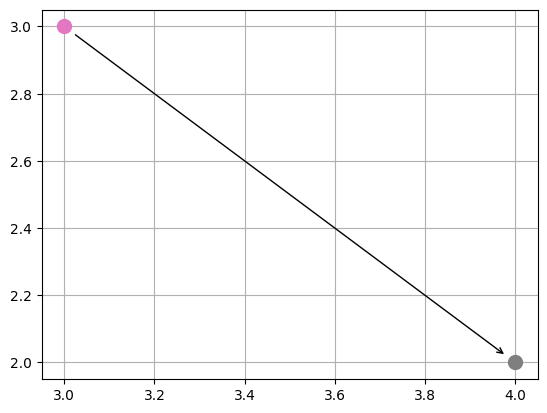

In [22]:
#!Solution
dep_flow_precise_T = dep_flow_precise.intersect(isl.Map("{T[i,j]->T[i',j']:}"))
sources1 = dep_flow_precise_T.intersect_range(point1)
sources2 = dep_flow_precise_T.intersect_range(point2)

plot_umap(sources1)

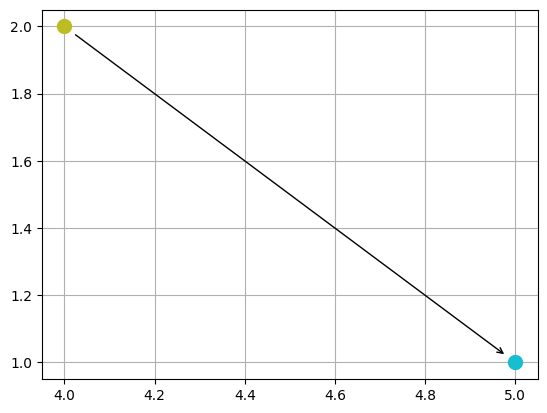

In [23]:
plot_umap(sources2)

As you may see, each `T` instance now depends exactly on only one other `T` instance.

*Memory-based* dependences can be recovered from *value-based* dependences by computing the transitive closure of the dependence relation.

### Question
Compute input dependences using *value-based* procedure.  Visualize their patterns.

In [24]:
#!Solution
uai = isl.UnionAccessInfo.from_sink(reads)
uai = uai.set_must_source(reads)
uai = uai.set_schedule(schedule)
flow = uai.compute_flow()
dep_input_precise = flow.get_may_dependence()
display_latex(dep_input_precise)

<IPython.core.display.Math object>